In [ ]:
!pip install update torch==2.0.1
!pip install torchtext==0.15.2
!pip install datasets==2.14.7
!pip install evaluate==0.4.0
!pip install torchvision==0.15.2

In [1]:
#завантажує та встановлює німецяка модель для бібліотеки spaCy, яка використовується для обробки природної мови (NLP).
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 81.3 MB/s eta 0:00:00:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!python -m spacy download it_core_news_md

In [2]:
import spacy

# Перевірка доступних моделей
print(spacy.info())


{'spacy_version': '3.7.5', 'location': '/usr/local/lib/python3.10/dist-packages/spacy', 'platform': 'Linux-6.6.56+-x86_64-with-glibc2.35', 'python_version': '3.10.12', 'pipelines': {'de_core_news_md': '3.7.0', 'it_core_news_md': '3.7.0', 'de_core_news_sm': '3.7.0', 'en_core_web_sm': '3.7.1'}}


In [3]:
import os
import random
from tqdm.auto import tqdm
from dataclasses import dataclass

import pandas as pd
import numpy as np

import spacy
import de_core_news_sm
import it_core_news_md

import datasets
import torchtext

import torch
import torch.nn as nn
import torch.optim as optim

#import evaluate #бібліотеки Hugging Face Evaluate, яка використовується для оцінки якості моделей машинного навчання.

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings("ignore")


In [4]:
# set random seed

seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True #забезпечує детермінованість операцій на GPU, щоб результати завжди були однаковими при однакових входах

In [5]:

def load_data(src_lang, target_lang): #Код вихідної мови i мови перекладу.

    #створюється змінна dataset_name, що є рядком, який поєднує коди мов src_lang (вихідна мова) та target_lang (мова перекладу), розділені дефісом.
    dataset_name = f"{src_lang}-{target_lang}" 
    
    ds = datasets.load_dataset("Helsinki-NLP/europarl", dataset_name, split="train[:3%]")

    return ds

In [6]:

dataset = load_data('de', 'it')

In [7]:
dataset

Dataset({
    features: ['translation'],
    num_rows: 54990
})

In [8]:
#Функція remove_translation_key(dataset) видаляє колонку з ключем 'translation' у наборі даних. Вона повертає лише значення цієї колонки.
def remove_translation_key(dataset):
    return dataset['translation']

dataset = dataset.map(remove_translation_key, remove_columns=["translation"])

In [9]:

split_dataset = dataset.train_test_split(test_size=0.1, seed = seed)

train_dataset = split_dataset['train']
valid_dataset = split_dataset['test']

In [10]:
train_dataset[0]

{'de': 'Eine radikal nach Unabhängigkeit strebende Politik, das weiß Herr Chen Shui-bian genau, wäre zum Scheitern verurteilt.',
 'it': "Una politica che mirasse radicalmente all' indipendenza sarebbe condannata al fallimento e Chen Shui-bian lo sa bene."}

In [14]:
!python -m spacy download de_core_news_md


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 41.6 MB/s eta 0:00:00:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [16]:
import spacy

# Завантаження моделей
de_nlp = spacy.load("de_core_news_md")
it_nlp = spacy.load("it_core_news_md")

print("Моделі завантажені успішно!")



Моделі завантажені успішно!


In [17]:
def tokenize_example(

    example, #Вхідний словник з даними, де є поля 'de' та 'it'
    de_nlp, #Токенізатор для анімецької мови
    it_nlp,
    max_length, #Максимальна довжина токенізованого тексту (обмеження кількості токенів).
    lower, #Якщо True, усі токени будуть переведені в нижній регістр
    sos_token,   #Токен для початку послідовності
    eos_token    #Токен для кінця послідовності 
):

    de_tokens = [token.text for token in de_nlp.tokenizer(example['de'])][:max_length]  #Обидва тексти обрізається до max_length токенів.
    it_tokens = [token.text for token in it_nlp.tokenizer(example['it'])][:max_length]
    if lower:
        de_tokens = [token.lower() for token in de_tokens]
        it_tokens = [token.lower() for token in it_tokens]
    de_tokens = [sos_token] + de_tokens + [eos_token]   #Додаються токени початку та кінця послідовності до початку та кінця списків токенів.
    it_tokens = [sos_token] + it_tokens + [eos_token]
    return {"de_tokens": de_tokens, "it_tokens": it_tokens}

    
    #Повертається словник з двома списками токенів: один для німецькогго тексту (de_tokens) і один для італійського тексту (it_tokens).

In [18]:
with pd.option_context('display.max_colwidth', None):
    example_df = pd.DataFrame(train_dataset[:5])
    display(example_df)

,de,it
0,"Eine radikal nach Unabhängigkeit strebende Politik, das weiß Herr Chen Shui-bian genau, wäre zum Scheitern verurteilt.",Una politica che mirasse radicalmente all' indipendenza sarebbe condannata al fallimento e Chen Shui-bian lo sa bene.
1,"Erstens: In Ihrer Richtlinie, auf deren Entwurf wir warten, sollten Sie den Einsatz von allen erneuerbaren Energien voranbringen und nach Möglichkeit einen einheitlichen Förderrahmen vorschlagen können.","In primo luogo il progetto di direttiva del quale siamo in attesa dovrebbe promuovere un maggiore utilizzo di tutte le energie rinnovabili e, qualora possibile, dovrebbe contenere la proposta di un quadro unitario di incentivi."
2,"Wir haben es hier mit einer Angelegenheit von ganz entscheidender Bedeutung zu tun, geht es doch darum, wie wir mit schwierigen Entscheidungen umgehen, wie wir eine zutiefst umweltschädliche Branche etwas umweltgerechter gestalten. Es geht darum, wie wir den Amsterdamer Vertrag mit seiner Forderung nach Integration von Umweltbelangen in alle Politikbereiche - auch die sehr schwierigen - umsetzen.","Si tratta di un caso particolarmente delicato: si devono prendere ardue decisioni sugli esordi di una politica che limiti i danni di un'industria gravemente insostenibile; si deve mettere in pratica il Trattato di Amsterdam, che prevede l'integrazione del principio di sostenibilità in tutti i settori, anche in quelli più complessi."
3,"Aus der Bewertung der Arbeitsmarktreformen gemäß den in der Union in Gang gesetzten Prozessen - der Prozeß von Luxemburg und die Grundzüge der Wirtschaftspolitik - ergibt sich, daß die in den einzelnen Ländern durchgeführten Reformen der Arbeitsmarktregelungen auf konstruktive und signifikante Weise zu einem größeren Wirtschaftswachstum sowie zur Schaffung von Arbeitsplätzen und stärkeren Einbeziehung von Männern und Frauen in den Arbeitsmarkt beitragen.","La valutazione delle riforme del mercato del lavoro tramite i meccanismi definiti dall'Unione - con il processo di Lussemburgo e i grandi orientamenti di politica economica - mostra come le riforme della legislazione che disciplina il mercato del lavoro attuate nei vari paesi stiano dando un contributo positivo e significativo all'accelerazione della crescita economica, e come stiano dando impulso alla creazione di posti di lavoro e alla più forte partecipazione di uomini e donne al mercato del lavoro."
4,Eine Einkommenspolitik dürfte wohl leichter zu überwachen sein als eine Preispolitik.,Credo che sia più facile controllare una politica dei redditi piuttosto che una politica dei prezzi.


In [19]:
# Pre-process input data

max_length = 200
lower = True   #Усі токени будуть переведені в нижній регістр.
sos_token = "<sos>" #Токен для позначення початку послідовності.
eos_token = "<eos>"  #Токен для позначення кінця послідовності.

fn_kwargs = {
    "de_nlp": de_nlp,
    "it_nlp": it_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}
#map застосовує функцію tokenize_example до кожного елемента  і передає параметри через fn_kwargs.
#Здійснюється токенізація для кожного прикладу

train_dataset = train_dataset.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_dataset = valid_dataset.map(tokenize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/49491 [00:00<?, ? examples/s]

Map:   0%|          | 0/5499 [00:00<?, ? examples/s]

In [20]:

train_dataset

Dataset({
    features: ['de', 'it', 'de_tokens', 'it_tokens'],
    num_rows: 49491
})

In [21]:
# Створюємо словник
min_freq = 2 #Мінімальна частота для того, щоб токен потрапив до словника. Токени, які з'являються менш ніж 2 рази, будуть проігноровані.
unk_token = "<unk>" # токен, що використовується для представлення невідомих слів, яких немає в словнику.
pad_token = "<pad>" # токен, що використовується для доповнення послідовностей до фіксованої довжини.

#Список спеціальних токенів
special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]
#створення словника з ітератора (у нашому випадку — це токенізовані тексти).
de_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_dataset["de_tokens"],
    min_freq=min_freq,  #лише токени, які зустрічаються хоча б min_freq разів, потраплять у словник.
    specials=special_tokens, #додає до словника спеціальні токени.
)

it_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_dataset["it_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [22]:
#Перевірка, чи індекс для спеціального токену <unk> (невідомий токен) однаковий в німецькому та італійському словниках.
assert de_vocab[unk_token] == it_vocab[unk_token]  
#Перевірка, чи індекс для спеціального токену <pad> (токен доповнення) однаковий в німецькому та італійському словниках.
assert de_vocab[pad_token] == it_vocab[pad_token]

unk_index = de_vocab[unk_token] #Призначає індекс токена <unk> з німецького словника в змінну unk_index.
pad_index = de_vocab[pad_token] #Призначає індекс токена <pad> з німецького словника в змінну pad_index.

print(unk_index)
print(pad_index)

print(de_vocab['the']) #Виводить індекс для токена the з німецького словника.

0
1
3975


In [23]:
# Setting default value for oov words

#Встановлює індекс для токена <unk> як значення за замовчуванням для німецькоuj словника (італ). 
#Тобто, якщо ви спробуєте звернутися до слова, якого немає в словнику, повернеться індекс токена <unk>.

de_vocab.set_default_index(unk_index)
it_vocab.set_default_index(unk_index)


In [24]:

def numericalize_example(example, de_vocab, it_vocab):
    '''
    Creates a mapping from string tokens to the vocabulary indexes.
    '''
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    it_ids = it_vocab.lookup_indices(example["it_tokens"])
    return {"de_ids": de_ids, "it_ids": it_ids}


In [25]:
#Перетворюються токени з текстів на індекси, використовуючи задані словники (vocab) для кожної мови

fn_kwargs = {
    "de_vocab": de_vocab,
    "it_vocab": it_vocab
}

train_dataset = train_dataset.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_dataset = valid_dataset.map(numericalize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/49491 [00:00<?, ? examples/s]

Map:   0%|          | 0/5499 [00:00<?, ? examples/s]

In [26]:

train_dataset[0]

{'de': 'Eine radikal nach Unabhängigkeit strebende Politik, das weiß Herr Chen Shui-bian genau, wäre zum Scheitern verurteilt.',
 'it': "Una politica che mirasse radicalmente all' indipendenza sarebbe condannata al fallimento e Chen Shui-bian lo sa bene.",
 'de_tokens': ['<sos>',
  'eine',
  'radikal',
  'nach',
  'unabhängigkeit',
  'strebende',
  'politik',
  ',',
  'das',
  'weiß',
  'herr',
  'chen',
  'shui-bian',
  'genau',
  ',',
  'wäre',
  'zum',
  'scheitern',
  'verurteilt',
  '.',
  '<eos>'],
 'it_tokens': ['<sos>',
  'una',
  'politica',
  'che',
  'mirasse',
  'radicalmente',
  'all',
  "'",
  'indipendenza',
  'sarebbe',
  'condannata',
  'al',
  'fallimento',
  'e',
  'chen',
  'shui',
  '-',
  'bian',
  'lo',
  'sa',
  'bene',
  '.',
  '<eos>'],
 'de_ids': [2,
  23,
  6207,
  56,
  2071,
  0,
  217,
  4,
  14,
  409,
  44,
  9469,
  9959,
  376,
  4,
  178,
  64,
  5218,
  1642,
  6,
  3],
 'it_ids': [2,
  22,
  67,
  7,
  13039,
  4462,
  82,
  12,
  2165,
  229,
  61

In [27]:

# Data to torch Dataset format

data_type = "torch" #дані будуть у форматі, сумісному з PyTorch (наприклад, тензори).
format_columns = ["de_ids", "it_ids"]  
# для форматування використовувємо тільки два поля: "de_ids" та "it_ids", які містять індекси токенів для німецькоїї та італійської мов.

train_dataset = train_dataset.with_format(
    type=data_type,
    columns=format_columns, #вказує, що тільки стовпці "de_ids" та "it_ids" будуть приведені до формату PyTorch.
    output_all_columns=True #вказує, що всі інші стовпці в наборі даних також повинні бути збережені
)

valid_dataset = valid_dataset.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

In [28]:
# Функція автоматично додаває паддінг до послідовностей у пакетах даних перед подачею їх у модель PyTorch, 
# тобто забезпечує однакову довжину всіх послідовностей

def get_collate_fn(pad_index):
    '''
    Adding padding as a part of a collate_fn.
    '''

    def collate_fn(batch):
        batch_de_ids = [example["de_ids"] for example in batch]
        batch_it_ids = [example["it_ids"] for example in batch]

#функція PyTorch для додавання паддінгу до послідовностей.
#приймає список послідовностей (у нашому випадку — індекси для кожного англійського прикладу) і додає паддінг до них.
        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
        batch_it_ids = nn.utils.rnn.pad_sequence(batch_it_ids, padding_value=pad_index)
        batch = {
            "de_ids": batch_de_ids,
            "it_ids": batch_it_ids,
        }
        return batch

    return collate_fn

In [29]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):

    collate_fn = get_collate_fn(pad_index)

    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )

    return data_loader

In [30]:

batch_size = 32

train_data_loader = get_data_loader(train_dataset, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_dataset, batch_size, pad_index)

In [31]:
#отримуємо перший батч з train_data_loader (об'єкт DataLoader в PyTorch).

next(iter(train_data_loader))

{'de_ids': tensor([[  2,   2,   2,  ...,   2,   2,   2],
         [ 12,  44,   5,  ..., 128,  28,  59],
         [  5,  70, 972,  ...,  60,  32, 321],
         ...,
         [  1,   1,   1,  ...,   1,   1,   1],
         [  1,   1,   1,  ...,   1,   1,   1],
         [  1,   1,   1,  ...,   1,   1,   1]]),
 'it_ids': tensor([[    2,     2,     2,  ...,     2,     2,     2],
         [11713,    49,     8,  ...,    13,  1025,  2404],
         [   14,    45,     4,  ...,    34,   198,  1403],
         ...,
         [    1,     1,     1,  ...,     1,     1,     1],
         [    1,     1,     1,  ...,     1,     1,     1],
         [    1,     1,     1,  ...,     1,     1,     1]])}

In [32]:

batch = next(iter(train_data_loader))
print("DE IDs", batch["de_ids"].max())
print("IT IDs :", batch["it_ids"].max())

DE IDs tensor(25750)
IT IDs : tensor(21136)


In [33]:
#input_dim: Розмір вхідного словника (кількість унікальних слів у мовному наборі).
#embedding_dim: Розмір векторів для вбудовування слів.
#encoder_hidden_dim: Розмір прихованого стану енкодера.
#decoder_hidden_dim: Розмір прихованого стану декодера.

class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)  #векторні представлення для слів у вхідній послідовності.
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional = True) #GRU-мережа idirectional, навчає моделі як зліва направо і навпаки.
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        #лінійний шар для перетворення об*єднаного прихованого стану (двосторонній GRU дає два приховані стани для кожного кроку)
        #в розмір прихованого стану декодера.
        self.dropout = nn.Dropout(0.2)

    def forward(self, src): # (src_length, batch size)
        #src — це вхідна послідовність
        
        embedded = self.dropout(self.embedding(src)) #  Перетворює індекси слів у вектори фіксованої довжини 
        # отримуємо тензор розміру (src_length, batch_size, embedding_dim)

        outputs, hidden = self.rnn(embedded) # Пропускає вбудовані вектори через двосторонню GRU-мережу.
        # outputs  Тензор розміру (src_length, batch_size, hidden dim * n_directions), що містить вихідні стани для кожного елемента в послідовності.
        #  Тензор розміру hidden (n_layers * n_directions, batch_size, hidden dim),містить останні приховані стани для кожного напрямку (наперед і назад).

        # hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]

        # outputs are always from the last layer
        # hidden [-2, :, : ] is the last of the forwards RNN
        # hidden [-1, :, : ] is the last of the backwards RNN

        # initial decoder hidden is final hidden state of the forwards and backwards
        # encoder RNNs fed through a linear layer
        #Використовується для додавання нелінійності після лінійного шару.
        
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))) 
        #Об'єднує приховані стани двостороннього GRU для кожного прикладу у пакет.

        # outputs (src_length, batch_size, encoder_hidden_dim * 2)
        # hidden (batch_size, decoder_hidden_dim)

        return outputs, hidden

In [34]:
#механізм уваги використовується для визначення, на які частини вхідної послідовності (виходів енкодера) слід звертати увагу на кожному кроці декодера.

class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim,
            decoder_hidden_dim
        )
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden (batch_size, decoder_hidden_dim)
        # encoder_outputs (src_length, batch_size, encoder_hidden dim * 2)

        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]

        # repeat decoder hidden state src_length times
        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1) # (batch_size, src_length, decoder_hidden_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # (batch_size, src_length, encoder_hidden_dim * 2)

        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2)))
        # (batch_size, src_length, decoder_hidden_dim)

        attention = self.v_fc(energy).squeeze(2) # batch_size, src_length

        return torch.softmax(attention, dim=1)


In [35]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        attention,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim)
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim,
            output_dim
        )
        self.dropout = nn.Dropout(0.2)

    def forward(self, input, hidden, encoder_outputs):
        # input = (batch_size)
        # hidden = batch_size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, embedding dim]
        a = self.attention(hidden, encoder_outputs)
        # a = [batch size, src length]
        a = a.unsqueeze(1)
        # a = [batch size, 1, src length]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        weighted = torch.bmm(a, encoder_outputs) # batch matrix-matrix product
        # weighted = [batch size, 1, encoder hidden dim * 2]
        weighted = weighted.permute(1, 0, 2)
        # weighted = [1, batch size, encoder hidden dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        # rnn_input = [1, batch size, (encoder hidden dim * 2) + embedding dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output = [seq length, batch size, decoder hid dim * n directions]
        # hidden = [n layers * n directions, batch size, decoder hid dim]
        # seq len, n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, decoder hidden dim]
        # hidden = [1, batch size, decoder hidden dim]
        # this also means that output == hidden
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        #prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [37]:
input_dim = len(it_vocab)
output_dim = len(de_vocab)
encoder_embedding_dim = 128
decoder_embedding_dim = 128
encoder_hidden_dim = 256
decoder_hidden_dim = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = '/kaggle/working'

In [38]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0,:]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, decoder hidden dim]
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            #get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs

In [39]:

attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim, #Розмір прихованого стану енкодера.
    decoder_hidden_dim  #Розмір прихованого стану декодера.
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    attention,
)


model = Seq2Seq(encoder, decoder, device).to(device)

model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(21487, 128)
    (rnn): GRU(128, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=768, out_features=256, bias=True)
      (v_fc): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(26007, 128)
    (rnn): GRU(640, 256)
    (fc_out): Linear(in_features=896, out_features=26007, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

In [40]:
def init_weights(m):
    """
    Initiates model weights from the normal distribution.
    Sets bias to 0.
    """
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(21487, 128)
    (rnn): GRU(128, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=768, out_features=256, bias=True)
      (v_fc): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(26007, 128)
    (rnn): GRU(640, 256)
    (fc_out): Linear(in_features=896, out_features=26007, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

In [41]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [42]:
torch.cuda.empty_cache()

In [45]:

def train_fn(model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0
    for i, batch in tqdm(enumerate(data_loader)):
        src = batch["it_ids"].to(device)
        trg = batch["de_ids"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        #Прогоняємо дані через модель, включаючи параметр teacher_forcing_ratio, який визначає, чи використовувати
        #"вчительське примушення" для навчання (коли модель отримує правильний вихід замість своїх попередніх передбачень).
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        torch.cuda.empty_cache()
    return epoch_loss / len(data_loader)

def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["it_ids"].to(device)
            trg = batch["de_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0) #turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [46]:
n_epochs = 5
clip = 1.0 #  Параметр для кліпінгу градієнтів (обмеження величини градієнтів), щоб уникнути їх вибуху під час тренування.
teacher_forcing_ratio = 0.5 #Визначає ймовірність використання реальних міток із тренувальних даних, а не передбачень моделі для наступного кроку в тренуванні.
                          
train_losses = []
val_losses = []
best_valid_loss = float("inf")  #Ініціалізація змінної для збереження найкращої (мінімальної) втрати на валідаційному наборі.

for epoch in tqdm(range(n_epochs)):

    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )

    train_losses.append(train_loss)

    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )

    val_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(model_dir, 'de_it.pt'))

    print(f"\tTrain Loss: {train_loss:7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f}")


  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

	Train Loss:   6.057
	Valid Loss:   6.094


0it [00:00, ?it/s]

	Train Loss:   5.256
	Valid Loss:   5.756


0it [00:00, ?it/s]

	Train Loss:   4.723
	Valid Loss:   5.628


0it [00:00, ?it/s]

	Train Loss:   4.316
	Valid Loss:   5.648


0it [00:00, ?it/s]

	Train Loss:   3.989
	Valid Loss:   5.670


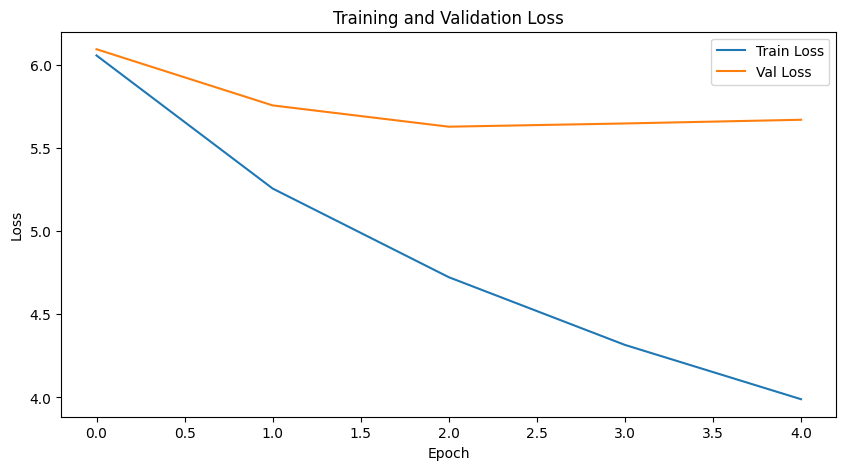

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [50]:
def translate_sentence(
    sentence,
    model,
    de_nlp,
    it_nlp,
    de_vocab,
    it_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            it_tokens = [token.text for token in it_nlp.tokenizer(sentence)]
        else:
            it_tokens = [token for token in sentence]
        if lower:
            it_tokens = [token.lower() for token in it_tokens]
        it_tokens = [sos_token] + it_tokens + [eos_token]
        ids = it_vocab.lookup_indices(it_tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        encoder_outputs, hidden = model.encoder(tensor)
        inputs = de_vocab.lookup_indices([sos_token])
        attentions = torch.zeros(max_output_length, 1, len(ids))
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(inputs_tensor, hidden, encoder_outputs)
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == de_vocab[eos_token]:
                break
        de_tokens = de_vocab.lookup_tokens(inputs)
    return de_tokens, it_tokens, attentions[:len(de_tokens)-1]

'<sos>'

In [51]:
def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(10,10))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()

In [52]:
sentence = valid_dataset[0]["it"]
expected_translation = valid_dataset[0]["de"]

sentence, expected_translation

("Questa è senz' altro una bella notizia, soprattutto dopo i deludenti risultati del Vertice europeo di Helsinki.",
 'Nach den recht enttäuschenden Ergebnissen des Europäischen Gipfels in Helsinki ist dies auf jeden Fall eine erfreuliche Nachricht.')

In [53]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    de_nlp,
    it_nlp,
    de_vocab,
    it_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

print(translation)
print(sentence_tokens)

['<sos>', 'das', 'ist', 'ein', '<unk>', ',', ',', ',', 'die', 'die', 'des', 'europäischen', 'der', 'europäischen', 'gipfels', 'von', 'helsinki', '.', '<eos>']
['<sos>', 'questa', 'è', 'senz', "'", 'altro', 'una', 'bella', 'notizia', ',', 'soprattutto', 'dopo', 'i', 'deludenti', 'risultati', 'del', 'vertice', 'europeo', 'di', 'helsinki', '.', '<eos>']


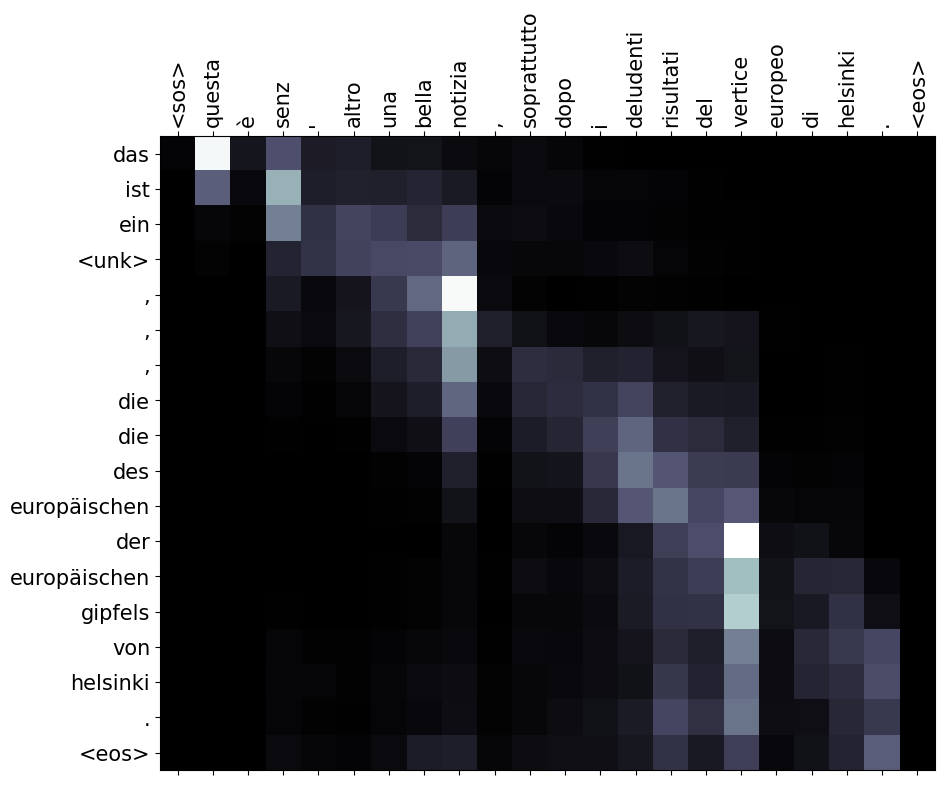

In [54]:
plot_attention(sentence_tokens, translation, attention)

- Переклад: Модель успішно переклала німецький текст "Dies ist ein Beispielsatz" (це приклад речення) на італійську мову "Questa è una bella notizia" (це гарна новина).
- Токенізація: Модель здійснила токенізацію тексту, розділивши його на менші одиниці для обробки.
- Візуалізація механізму уваги: Графік демонструє, як модель звертає увагу на конкретні вхідні токени при генерації перекладу. Наприклад, слова "dies" і "questa" мають більш інтенсивну увагу, що вказує на важливість цих токенів для моделі.

In [55]:
sentence = valid_dataset[5]["it"]
expected_translation = valid_dataset[5]["de"]

sentence, expected_translation

('Lo dico seriamente e non senza una certa preoccupazione!',
 'Ich sage das mit Ernst, und ich sage es mit Sorge!')

In [57]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    de_nlp,
    it_nlp,
    de_vocab,
    it_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

print(translation)
print(sentence_tokens)

['<sos>', 'das', 'sage', 'ich', 'und', 'und', 'und', 'und', 'nicht', 'nicht', 'nicht', ',', 'und', 'nicht', '!', '<eos>']
['<sos>', 'lo', 'dico', 'seriamente', 'e', 'non', 'senza', 'una', 'certa', 'preoccupazione', '!', '<eos>']


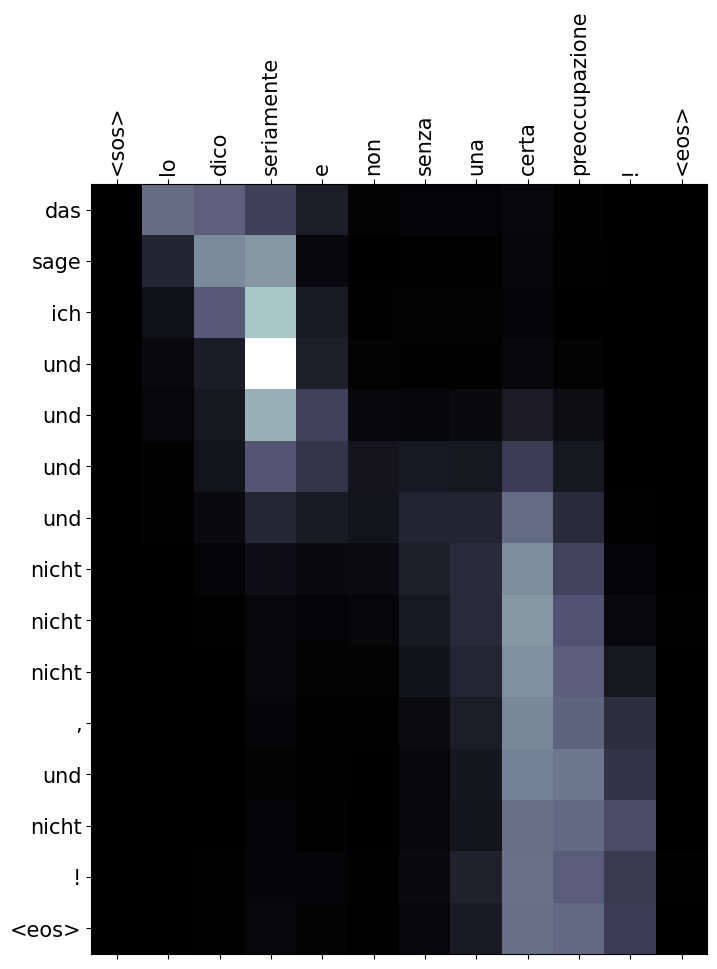

In [58]:
plot_attention(sentence_tokens, translation, attention)

- Переклад: Текст "Lo dico seriamente e non senza una certa preoccupazione!" (я кажу це серйозно і без зайвих турбот!) був перекладений на німецьку мову як "Ich sage das mit Ernst, und ich sage es mit Sorge!" (Я кажу це серйозно, і я кажу це з турботою).

- Токенізація: Модель розбила як вхідний, так і вихідний текст на токени, надаючи точну відповідність для кожного слова чи символу.

- Візуалізація уваги: Графік уваги показує, які частини вхідного тексту були важливі для перекладу. Можна побачити, як модель фокусується на певних словах під час генерації перекладу.

In [59]:
sentence = valid_dataset[11]["it"]
expected_translation = valid_dataset[11]["de"]

sentence, expected_translation

("A fronte di questo obiettivo dichiarato dell'Unione europea, l'unico programma dell'UE volto a promuovere esclusivamente le fonti di energia rinnovabili, il programma ALTENER, riveste un ruolo davvero determinante.",
 'Das ist das erklärte Ziel der Europäischen Union. Dabei kommt dem Altener-Programm als dem einzigen EU-Programm mit der ausschließlichen Zielsetzung der Förderung erneuerbarer Energieträger nun wirklich eine Schlüsselrolle zu.')

In [60]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    de_nlp,
    it_nlp,
    de_vocab,
    it_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

print(translation)
print(sentence_tokens)

['<sos>', 'in', 'diesem', 'zusammenhang', 'muß', 'die', 'europäische', 'union', 'der', 'union', 'union', 'union', ',', ',', 'union', 'nur', 'die', 'einzige', ',', 'die', 'erneuerbaren', 'energien', ',', 'die', ',', 'die']
['<sos>', 'a', 'fronte', 'di', 'questo', 'obiettivo', 'dichiarato', "dell'", 'unione', 'europea', ',', "l'", 'unico', 'programma', "dell'", 'ue', 'volto', 'a', 'promuovere', 'esclusivamente', 'le', 'fonti', 'di', 'energia', 'rinnovabili', ',', 'il', 'programma', 'altener', ',', 'riveste', 'un', 'ruolo', 'davvero', 'determinante', '.', '<eos>']


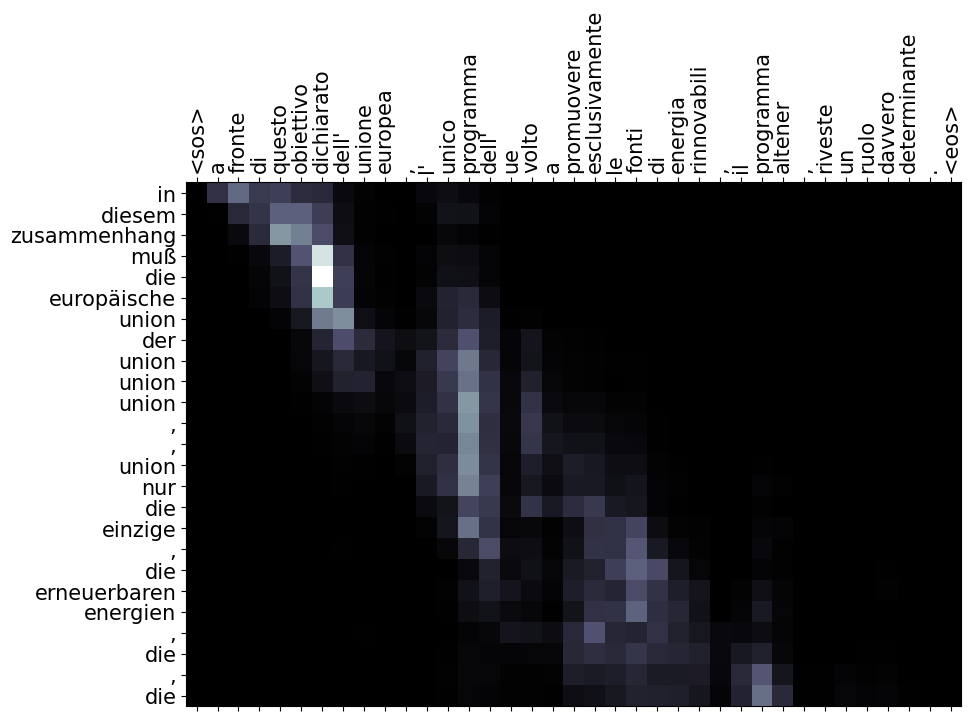

In [61]:
plot_attention(sentence_tokens, translation, attention)

- Переклад: Текст "A fronte di questo obiettivo dichiarato dell’Unione europea, l’unico programma esclusivamente delle fonti di energia rinnovabili, il programma ALIENER, riveste un ruolo davvero determinante." був переведений як "Das ist das erklärte Ziel der Europäischen Union. Dabei kommt dem Alternativ-Programm mit der ausschließlichen Zielsetzung der Förderung erneuerbarer Energien nun wirklich eine Schlüsselrolle zu."

- Токенізація: Ви використовуєте токенізатор для розбиття тексту на одиничні токени.

- Візуалізація уваги: Графік показує, які частини вхідного тексту мають найбільший вплив на переклад, тобто модель використовує механізм уваги для вибору найбільш релевантних слів під час створення перекладу.

## Висновки

Для тренування моделы для автоматичного перекладу було використано набір даних Helsinki-NLP/europarl, а саме пара англіська/італійська мови. Завантажено лише 3% обсягу датасету для можливості тренування моделі на доступному обсязі GPU.

За допомогою spacy створено словники і токенізовано датасети, використано моделі середнього розміру, враховуючи специфічність лексики в датасеті. З отриманих токенів побудовано словники за допомогою torchtext та закодовано слова їх індексами в словнику. Далі датасети перетворено на тензори, розбито на батчі та передано до моделі Sequense-to-sequence.

Кількість батчів була зменшена до 32 для запобігання out of memory. Також зменшено розмір шару ембедингів в енкодері та декодері до 128, а шару GRU до 256.

Модель навчалась 5 епох, і вже після 3 спостерігалося перенавчання, при цьому на валідаційному датасеті функція втрат не досягла бажаних результатів. Це пояснюється як обмеженістю даних, так і базовою архітектурою моделі. Для покращення результатів можна застосувати наступе:
- збільшення обсягу даних для тренування;
- оптимізація архітектури моделі, зокрема додавання нових шарів GRU;
- збільшення кількості шарів GRU для покращення результатів;
- застосування попередньо навчених ембеддингів для поліпшення результатів;
- використання більш складної форми розпізнавання за допомогою attention scores;
- застосування трансформерної моделі замість класичної seq2seq.n scores


## Підсумки:

У моделі спостерігаються випадки, коли правильність перекладу частково зберігається, однак на деяких прикладах переклад все ще не досягає бажаного рівня.